In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import time

import scipy.stats as stats
import pandas as pd
import seaborn as sns

In [105]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data=pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] 
columns=data.keys()
cols2zscore=columns.drop('quality')
for col in cols2zscore:
    meanval=np.mean(data[col])
    stdev=np.std(data[col],ddof=1)
    data[col]=(data[col]-meanval)/stdev

data['boolQuality']=0
data['boolQuality'][data['quality']>5]=1
data[['quality','boolQuality']]

<ipython-input-105-5fefd8b08be9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality']>5]=1


,quality,boolQuality
0,5,0
1,5,0
2,5,0
3,6,1
4,5,0
...,...,...
1594,5,0
1595,6,1
1596,6,1
1597,5,0


In [106]:
data_train=torch.tensor(data[cols2zscore].values).float()
labels=tr=torch.tensor(data['boolQuality'].values).float()
labels=labels[:,None]
print(data_train.shape)
print(labels.shape)

train_data,test_data,train_label,test_label=train_test_split(data_train,labels,test_size=0.1)

train_data=TensorDataset(train_data,train_label)
test_data=TensorDataset(test_data,test_label)

torch.Size([1597, 11])
torch.Size([1597, 1])


In [45]:
class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()
        #input layer
        self.input=nn.Linear(11,16)
        #hidden layer
        self.fc1=nn.Linear(16,32)
        self.fc2=nn.Linear(32,32)
        #output layer
        self.output=nn.Linear(32,1)
    
    def forward(self,x):
        x=F.relu(self.input(x))
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        return self.output(x)

In [81]:
def createModel():
    ANN=ANNwine()
    lossfun=nn.BCEWithLogitsLoss()
    optimizer=torch.optim.SGD(ANN.parameters(),lr=.01)
    return ANN,lossfun,optimizer

In [121]:
def trainModel(Train_data=None,Test_data=None,ANN=None,\
               lossfun=None,optimizer=None,Numepoch=1000):
    trainAcc=[]
    testAcc=[]
    losses=torch.zeros(Numepoch)

    for epoch in range(Numepoch):
        ANN.train()

        batchAcc=[]
        batchLoss=[]

        for dat,lab in Train_data:
            #forward 
            yHat=ANN(dat)
            loss=lossfun(yHat,lab)

            #backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchAcc.append(100*torch.mean(((yHat>0)==lab).float()).item())
            batchLoss.append(loss.item())

        trainAcc.append(np.mean(batchAcc))
        losses[epoch]=np.mean(batchLoss)

        #testing on epoch
        ANN.eval()
        dat,lab=next(iter(Test_data))
        with torch.no_grad():
            yHat=ANN(dat)
        testAcc.append(100*torch.mean(((yHat>0)==lab).float()).item() )
    return trainAcc,testAcc,losses

In [122]:
train_loader=DataLoader(train_data,batch_size=64,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])
for dat,lab in train_loader:
    print(dat.shape,lab.shape)
ANN,lossfun,optimizer=createModel()
trainAcc,testAcc,losses=trainModel(train_loader,test_loader,ANN,\
                                   lossfun,optimizer,100)


complement time:141.52773069299997


Text(0.5, 1.0, 'last loss values:0.1990371197462082')

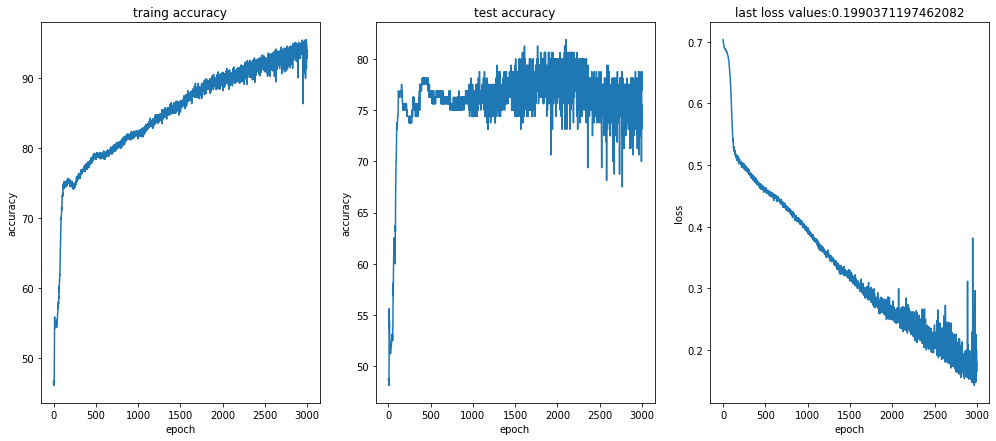

In [104]:
fig,axs=plt.subplots(1,3,figsize=(17,7))
axs[0].plot(trainAcc)
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('accuracy')
axs[0].set_title('traing accuracy')

axs[1].plot(testAcc)
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
axs[1].set_title('test accuracy')

axs[2].plot(losses)
axs[2].set_xlabel('epoch')
axs[2].set_ylabel('loss')
axs[2].set_title(f'last loss values:{losses[-1]}')

In [127]:
batchsizes=2**np.arange(1,10,2)
numepochs=1000

accuracyTrain=np.zeros((numepochs,len(batchsizes)))
accuracyTest=np.zeros((numepochs,len(batchsizes)))
comptimes=np.zeros(len(batchsizes))

test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

for i in range(len(batchsizes)):
    start_time=time.process_time()
    train_loader=DataLoader(train_data,batch_size=int(batchsizes[i]),\
                            shuffle=True,drop_last=True)
    ANN,lossfun,optimizer=createModel()
    trainAcc,testAcc,losses=trainModel(train_loader,test_loader,ANN,\
                                   lossfun,optimizer,numepochs)
    accuracyTrain[:,i]=trainAcc
    accuracyTest[:,i]=testAcc
    comptimes[i]=time.process_time()-start_time
    

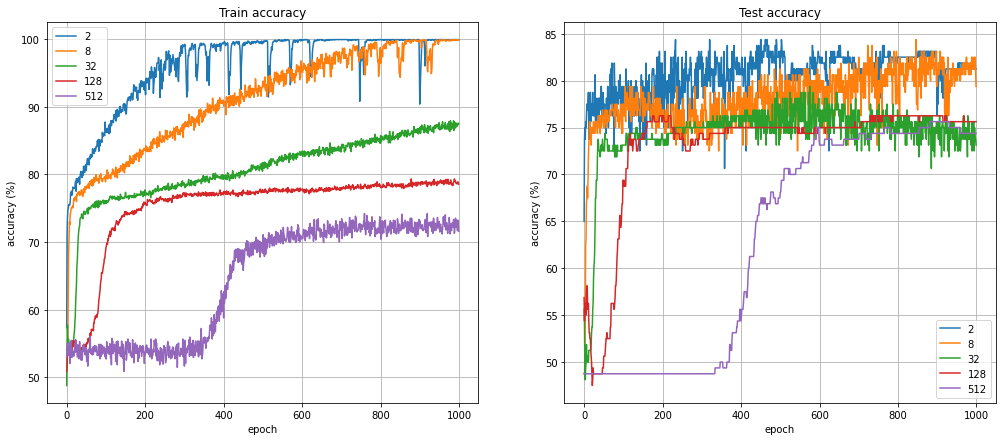

<BarContainer object of 5 artists>

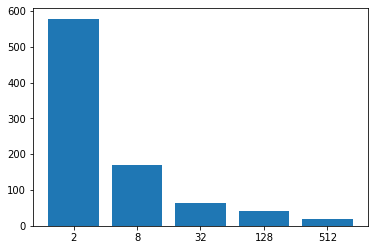

In [128]:
fig,axs=plt.subplots(1,2,figsize=(17,7))
axs[0].plot(accuracyTrain)
axs[0].set_title('Train accuracy')
axs[1].plot(accuracyTest)
axs[1].set_title('Test accuracy')
for i in range(2):
    axs[i].legend(batchsizes)
    axs[i].set_xlabel('epoch')
    axs[i].set_ylabel('accuracy (%)')
    axs[i].grid()
plt.show()

plt.bar(range(len(comptimes)),comptimes,tick_label=batchsizes)